In [14]:
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import nltk
import keras



In [15]:
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='train')

train_data = np.array(train.data)
test_data = np.array(test.data)
y_train = train.target
y_test = test.target

class_list = list(train.target_names)

In [16]:
from sklearn.metrics import roc_auc_score
def mean_roc_auc(y_true, y_pred):
    y = np.array(y_true.copy())
    probas = np.array(y_pred.copy())
    rs = []
    for i in range(len(class_list)):
        r = roc_auc_score((y==i).astype(int), probas[:, i])
        rs.append(r)
    return np.mean(rs)

In [17]:
maxlen = 50
def gen(texts, labels):
    for text, label in zip(texts, labels):
        tokens = nltk.word_tokenize(text)
        len_tokens = 50 #len(tokens)
        tokens = tokens[:maxlen] if len(tokens)>=maxlen else tokens + ['<end>']*(maxlen - len(tokens))
        tokens = np.array(tokens)
        yield tokens, len_tokens, label

def parser(tokens, len_tokens, label):
    return {'tokens': tokens, 'len_tokens': len_tokens}, label
  
def input_fn(texts, labels, params, is_training):
    dataset = tf.data.Dataset.from_generator(lambda:gen(texts, labels), 
                                            (tf.string, tf.int32, tf.int32),
                                              output_shapes=(tf.TensorShape([None]), tf.TensorShape([]), tf.TensorShape([])))
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(texts))
    dataset = dataset.batch(params['batch_size'])
    dataset = dataset.map(parser)
    if is_training:
        dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [18]:
NUM_CLASSES = len(class_list)
head = tf.contrib.estimator.multi_class_head(NUM_CLASSES)

def create_model(features, params, is_training):
    def get_logits(x):
        elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=False)
        tokens_input = x['tokens']
        tokens_length = x['len_tokens']
        embeddings = elmo(
            inputs={
                    "tokens": tokens_input,
                    "sequence_len": tokens_length
                    },
                    signature="tokens",
                    as_dict=True)
        
        output_layer = embeddings["elmo"]
        lstm_cell_1 = tf.nn.rnn_cell.GRUCell(100)
        outputs, final_states = tf.nn.dynamic_rnn(
            lstm_cell_1, output_layer, dtype=tf.float32)
        max_pool = tf.reduce_max(input_tensor=outputs, axis=1)
        mean_pool = tf.reduce_mean(input_tensor=outputs, axis=1)
        concat_outputs = tf.concat((mean_pool, max_pool, final_states),1)


        dropout_concat_outputs = tf.layers.dropout(inputs=concat_outputs, 
                                         rate=0.2, 
                                         training=is_training)
        dense = tf.layers.dense(dropout_concat_outputs, 100)
        model_output = tf.layers.dense(dense, params['num_labels'])
        return model_output
        
    with tf.variable_scope('encoder'):
        logits = get_logits(features)
    
    return logits

def model_fn(features, labels, mode, params): 
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    with tf.variable_scope('model'):
        logits = create_model(features, params, is_training)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        class_nums = tf.argmax(logits,1)
        probas = tf.nn.softmax(logits)
        predictions = {'y':class_nums, 'probas':probas}
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    if mode ==  tf.estimator.ModeKeys.EVAL:
        probas = tf.nn.softmax(logits)
        aucs = []
        for i in range(len(class_list)):
            auc = tf.metrics.auc(labels, probas[:, i])
            aucs.append(auc)
        mean_auc = tf.reduce_mean(aucs)
        tf.summary.scalar('mean_auc', mean_auc)
#         metrics = {'mean_auc': mean_auc}
        loss = tf.losses.sparse_softmax_cross_entropy(labels, logits)
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss)
    
    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)


In [19]:
params = {
         'num_labels': len(class_list),
         'batch_size': 4}

def get_part_of_data(data, y, count_per_class):
    new_data = []
    new_labels = []
    for label, _ in enumerate(class_list):
        idxs = np.where(y==label)[0]
        idxs = np.random.choice(idxs, count_per_class).astype(int)
        new_data.extend([_ for _ in data[idxs]])
        new_labels.extend([_ for _ in y[idxs]])
    return new_data, new_labels

In [20]:
aucs = []
for count_examples in range(1,20):
    model_dir = f'elmo_exp_{count_examples}'
    estimator = tf.estimator.Estimator(model_fn=model_fn,
                                       model_dir=model_dir,
                                       params=params)
    c_steps = int((count_examples*len(class_list)/params['batch_size'])*2)

    new_train_data, new_y_train = get_part_of_data(train_data, y_train, count_examples)

    estimator.train(input_fn=lambda: input_fn(train_data, y_train, params, is_training=True), steps=c_steps)
    
    new_test_data, new_y_test = get_part_of_data(test_data, y_test, 4)
    y_pred = estimator.predict(input_fn=lambda: input_fn(new_test_data, new_y_test, params, False))
    y_pred = [_ for _ in tqdm(y_pred)]

    auc = mean_roc_auc(new_y_test, [_['probas'] for _ in y_pred])
    aucs.append(auc)
    print(count_examples, auc)


INFO:tensorflow:Using default config.


I0413 21:16:11.272492 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8565BA90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:16:11.276466 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8565BA90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:16:11.349317 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:16:12.375909 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:16:13.766433 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:16:14.515398 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:16:14.517392 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:16:14.719851 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_1\model.ckpt-20


I0413 21:16:14.727837 16732 saver.py:1270] Restoring parameters from elmo_exp_1\model.ckpt-20


INFO:tensorflow:Running local_init_op.


I0413 21:16:15.548745 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:16:15.600638 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 20 into elmo_exp_1\model.ckpt.


I0413 21:16:22.433031 16732 basic_session_run_hooks.py:594] Saving checkpoints for 20 into elmo_exp_1\model.ckpt.


INFO:tensorflow:loss = 3.327341, step = 21


I0413 21:17:05.519989 16732 basic_session_run_hooks.py:249] loss = 3.327341, step = 21


INFO:tensorflow:Saving checkpoints for 30 into elmo_exp_1\model.ckpt.


I0413 21:17:50.605381 16732 basic_session_run_hooks.py:594] Saving checkpoints for 30 into elmo_exp_1\model.ckpt.


INFO:tensorflow:Loss for final step: 2.8240566.


I0413 21:17:58.181273 16732 estimator.py:359] Loss for final step: 2.8240566.


INFO:tensorflow:Calling model_fn.


I0413 21:17:58.284949 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:17:59.553339 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:18:00.709248 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:18:00.932650 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 21:18:01.093220 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_1\model.ckpt-30


I0413 21:18:01.099173 16732 saver.py:1270] Restoring parameters from elmo_exp_1\model.ckpt-30


INFO:tensorflow:Running local_init_op.


I0413 21:18:01.778382 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:18:01.825393 16732 session_manager.py:493] Done running local_init_op.


1 0.6580592105263158
INFO:tensorflow:Using default config.


I0413 21:19:37.305933 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C81DAEEF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:19:37.308925 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C81DAEEF0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:19:37.379767 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:19:38.561606 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:19:39.675630 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:19:40.377753 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:19:40.379730 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:19:40.716586 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_2\model.ckpt-20


I0413 21:19:40.723253 16732 saver.py:1270] Restoring parameters from elmo_exp_2\model.ckpt-20


INFO:tensorflow:Running local_init_op.


I0413 21:19:41.452761 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:19:41.502489 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 20 into elmo_exp_2\model.ckpt.


I0413 21:19:47.907124 16732 basic_session_run_hooks.py:594] Saving checkpoints for 20 into elmo_exp_2\model.ckpt.


INFO:tensorflow:loss = 3.023277, step = 21


I0413 21:20:32.203932 16732 basic_session_run_hooks.py:249] loss = 3.023277, step = 21


INFO:tensorflow:Saving checkpoints for 40 into elmo_exp_2\model.ckpt.


I0413 21:22:02.272856 16732 basic_session_run_hooks.py:594] Saving checkpoints for 40 into elmo_exp_2\model.ckpt.


INFO:tensorflow:Loss for final step: 3.2367043.


I0413 21:22:09.550340 16732 estimator.py:359] Loss for final step: 3.2367043.


INFO:tensorflow:Calling model_fn.


I0413 21:22:09.648070 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:22:10.613634 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:22:11.848150 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:22:12.062575 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 21:22:12.222131 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_2\model.ckpt-40


I0413 21:22:12.228101 16732 saver.py:1270] Restoring parameters from elmo_exp_2\model.ckpt-40


INFO:tensorflow:Running local_init_op.


I0413 21:22:12.896797 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:22:12.940710 16732 session_manager.py:493] Done running local_init_op.


2 0.6049342105263158
INFO:tensorflow:Using default config.


I0413 21:23:43.943094 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C884BF0B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:23:43.945090 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C884BF0B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:23:44.024908 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:23:45.234060 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:23:46.362072 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:23:47.045246 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:23:47.047235 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:23:47.239695 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_3\model.ckpt-16


I0413 21:23:47.261668 16732 saver.py:1270] Restoring parameters from elmo_exp_3\model.ckpt-16


INFO:tensorflow:Running local_init_op.


I0413 21:23:47.976656 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:23:48.026491 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 16 into elmo_exp_3\model.ckpt.


I0413 21:23:54.373779 16732 basic_session_run_hooks.py:594] Saving checkpoints for 16 into elmo_exp_3\model.ckpt.


INFO:tensorflow:loss = 3.2464943, step = 17


I0413 21:24:37.346639 16732 basic_session_run_hooks.py:249] loss = 3.2464943, step = 17


INFO:tensorflow:Saving checkpoints for 46 into elmo_exp_3\model.ckpt.


I0413 21:26:50.577407 16732 basic_session_run_hooks.py:594] Saving checkpoints for 46 into elmo_exp_3\model.ckpt.


INFO:tensorflow:Loss for final step: 2.872704.


I0413 21:26:57.811657 16732 estimator.py:359] Loss for final step: 2.872704.


INFO:tensorflow:Calling model_fn.


I0413 21:26:57.913385 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:26:59.131045 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:27:00.219135 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:27:00.434558 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 21:27:00.588148 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_3\model.ckpt-46


I0413 21:27:00.595098 16732 saver.py:1270] Restoring parameters from elmo_exp_3\model.ckpt-46


INFO:tensorflow:Running local_init_op.


I0413 21:27:01.265303 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:27:01.307205 16732 session_manager.py:493] Done running local_init_op.


3 0.6620065789473684
INFO:tensorflow:Using default config.


I0413 21:28:32.567324 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8D3665C0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:28:32.569332 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8D3665C0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:28:32.666061 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:28:33.988799 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:28:35.125758 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:28:35.789979 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:28:35.792970 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:28:40.439945 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 21:28:40.874276 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:28:40.924678 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_4\model.ckpt.


I0413 21:28:47.216286 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_4\model.ckpt.


INFO:tensorflow:loss = 3.4545615, step = 1


I0413 21:29:31.011141 16732 basic_session_run_hooks.py:249] loss = 3.4545615, step = 1


INFO:tensorflow:Saving checkpoints for 40 into elmo_exp_4\model.ckpt.


I0413 21:32:13.629886 16732 basic_session_run_hooks.py:594] Saving checkpoints for 40 into elmo_exp_4\model.ckpt.


INFO:tensorflow:Loss for final step: 3.0804093.


I0413 21:32:21.151791 16732 estimator.py:359] Loss for final step: 3.0804093.


INFO:tensorflow:Calling model_fn.


I0413 21:32:21.258506 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:32:22.466817 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:32:23.563881 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:32:23.781300 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 21:32:23.933860 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_4\model.ckpt-40


I0413 21:32:23.939848 16732 saver.py:1270] Restoring parameters from elmo_exp_4\model.ckpt-40


INFO:tensorflow:Running local_init_op.


I0413 21:32:24.614552 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:32:24.658476 16732 session_manager.py:493] Done running local_init_op.


4 0.6296052631578948
INFO:tensorflow:Using default config.


I0413 21:33:55.969274 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020BCD5A8D30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:33:55.971268 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020BCD5A8D30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:33:56.070036 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:33:57.253092 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:33:58.348961 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:33:59.160791 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:33:59.161755 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:34:03.554625 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 21:34:03.998546 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:34:04.050395 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_5\model.ckpt.


I0413 21:34:10.494956 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_5\model.ckpt.


INFO:tensorflow:loss = 3.5798635, step = 1


I0413 21:34:52.602369 16732 basic_session_run_hooks.py:249] loss = 3.5798635, step = 1


INFO:tensorflow:Saving checkpoints for 50 into elmo_exp_5\model.ckpt.


I0413 21:38:17.990944 16732 basic_session_run_hooks.py:594] Saving checkpoints for 50 into elmo_exp_5\model.ckpt.


INFO:tensorflow:Loss for final step: 2.5554905.


I0413 21:38:25.608895 16732 estimator.py:359] Loss for final step: 2.5554905.


INFO:tensorflow:Calling model_fn.


I0413 21:38:25.720565 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:38:26.666266 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:38:27.864063 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:38:28.079518 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 21:38:28.234105 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_5\model.ckpt-50


I0413 21:38:28.240056 16732 saver.py:1270] Restoring parameters from elmo_exp_5\model.ckpt-50


INFO:tensorflow:Running local_init_op.


I0413 21:38:28.906584 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:38:28.950444 16732 session_manager.py:493] Done running local_init_op.


5 0.6606907894736842
INFO:tensorflow:Using default config.


I0413 21:40:00.441272 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C83FBD128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:40:00.443268 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C83FBD128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:40:00.546989 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:40:01.867735 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:40:02.993752 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:40:03.665953 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:40:03.668929 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:40:08.312470 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 21:40:08.769280 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:40:08.820112 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_6\model.ckpt.


I0413 21:40:15.115391 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_6\model.ckpt.


INFO:tensorflow:loss = 3.087284, step = 1


I0413 21:40:57.385168 16732 basic_session_run_hooks.py:249] loss = 3.087284, step = 1


INFO:tensorflow:Saving checkpoints for 60 into elmo_exp_6\model.ckpt.


I0413 21:45:05.365159 16732 basic_session_run_hooks.py:594] Saving checkpoints for 60 into elmo_exp_6\model.ckpt.


INFO:tensorflow:Loss for final step: 3.2260087.


I0413 21:45:13.103184 16732 estimator.py:359] Loss for final step: 3.2260087.


INFO:tensorflow:Calling model_fn.


I0413 21:45:13.226883 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:45:14.442246 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:45:15.555040 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:45:15.773107 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 21:45:15.930682 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_6\model.ckpt-60


I0413 21:45:15.937636 16732 saver.py:1270] Restoring parameters from elmo_exp_6\model.ckpt-60


INFO:tensorflow:Running local_init_op.


I0413 21:45:16.613082 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:45:16.659925 16732 session_manager.py:493] Done running local_init_op.


6 0.6962171052631578
INFO:tensorflow:Using default config.


I0413 21:46:48.519295 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C84B89B38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:46:48.521291 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C84B89B38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:46:48.636981 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:46:49.818529 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:46:50.908610 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:46:51.731411 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:46:51.733376 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:46:56.247292 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 21:46:56.680115 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:46:56.730615 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_7\model.ckpt.


I0413 21:47:03.011357 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_7\model.ckpt.


INFO:tensorflow:loss = 3.2104764, step = 1


I0413 21:47:45.953688 16732 basic_session_run_hooks.py:249] loss = 3.2104764, step = 1


INFO:tensorflow:Saving checkpoints for 70 into elmo_exp_7\model.ckpt.


I0413 21:52:34.275070 16732 basic_session_run_hooks.py:594] Saving checkpoints for 70 into elmo_exp_7\model.ckpt.


INFO:tensorflow:Loss for final step: 3.5166013.


I0413 21:52:41.935634 16732 estimator.py:359] Loss for final step: 3.5166013.


INFO:tensorflow:Calling model_fn.


I0413 21:52:42.043341 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:52:43.284510 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:52:44.432443 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:52:44.648860 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 21:52:44.802449 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_7\model.ckpt-70


I0413 21:52:44.808402 16732 saver.py:1270] Restoring parameters from elmo_exp_7\model.ckpt-70


INFO:tensorflow:Running local_init_op.


I0413 21:52:45.478546 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:52:45.520262 16732 session_manager.py:493] Done running local_init_op.


7 0.7077302631578949
INFO:tensorflow:Using default config.


I0413 21:54:16.466131 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C89CF3160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 21:54:16.468126 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C89CF3160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 21:54:16.572871 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:54:17.755764 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 21:54:18.857849 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 21:54:19.534040 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 21:54:19.536911 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 21:54:24.094719 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 21:54:24.542953 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 21:54:24.594324 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_8\model.ckpt.


I0413 21:54:30.905187 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_8\model.ckpt.


INFO:tensorflow:loss = 3.0085235, step = 1


I0413 21:55:13.311832 16732 basic_session_run_hooks.py:249] loss = 3.0085235, step = 1


INFO:tensorflow:Saving checkpoints for 80 into elmo_exp_8\model.ckpt.


I0413 22:00:44.399472 16732 basic_session_run_hooks.py:594] Saving checkpoints for 80 into elmo_exp_8\model.ckpt.


INFO:tensorflow:Loss for final step: 3.1719549.


I0413 22:00:51.739197 16732 estimator.py:359] Loss for final step: 3.1719549.


INFO:tensorflow:Calling model_fn.


I0413 22:00:51.843917 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:00:53.072417 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:00:54.214362 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:00:54.428788 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 22:00:54.584372 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_8\model.ckpt-80


I0413 22:00:54.591322 16732 saver.py:1270] Restoring parameters from elmo_exp_8\model.ckpt-80


INFO:tensorflow:Running local_init_op.


I0413 22:00:55.260282 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:00:55.302553 16732 session_manager.py:493] Done running local_init_op.


8 0.722203947368421
INFO:tensorflow:Using default config.


I0413 22:02:26.462802 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C839216D8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 22:02:26.463819 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C839216D8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 22:02:26.604454 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:02:27.787139 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:02:28.881215 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:02:29.553415 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 22:02:29.555384 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 22:02:34.154073 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 22:02:34.607841 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:02:34.659512 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_9\model.ckpt.


I0413 22:02:40.956902 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_9\model.ckpt.


INFO:tensorflow:loss = 3.0968385, step = 1


I0413 22:03:24.342588 16732 basic_session_run_hooks.py:249] loss = 3.0968385, step = 1


INFO:tensorflow:Saving checkpoints for 90 into elmo_exp_9\model.ckpt.


I0413 22:10:14.575061 16732 basic_session_run_hooks.py:594] Saving checkpoints for 90 into elmo_exp_9\model.ckpt.


INFO:tensorflow:Loss for final step: 3.227269.


I0413 22:10:22.658726 16732 estimator.py:359] Loss for final step: 3.227269.


INFO:tensorflow:Calling model_fn.


I0413 22:10:22.818274 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:10:24.258314 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:10:25.781257 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:10:26.018636 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 22:10:26.211122 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_9\model.ckpt-90


I0413 22:10:26.220067 16732 saver.py:1270] Restoring parameters from elmo_exp_9\model.ckpt-90


INFO:tensorflow:Running local_init_op.


I0413 22:10:27.000819 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:10:27.045675 16732 session_manager.py:493] Done running local_init_op.


9 0.7978618421052632
INFO:tensorflow:Using default config.


I0413 22:12:09.221428 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C854D4780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 22:12:09.223423 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C854D4780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 22:12:09.341386 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:12:10.551447 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:12:11.651505 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:12:12.323706 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 22:12:12.326668 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 22:12:16.870229 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 22:12:17.312864 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:12:17.361861 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_10\model.ckpt.


I0413 22:12:23.805242 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_10\model.ckpt.


INFO:tensorflow:loss = 2.9213655, step = 1


I0413 22:13:06.493609 16732 basic_session_run_hooks.py:249] loss = 2.9213655, step = 1


INFO:tensorflow:Saving checkpoints for 100 into elmo_exp_10\model.ckpt.


I0413 22:20:38.129703 16732 basic_session_run_hooks.py:594] Saving checkpoints for 100 into elmo_exp_10\model.ckpt.


INFO:tensorflow:Loss for final step: 2.2183108.


I0413 22:20:45.572777 16732 estimator.py:359] Loss for final step: 2.2183108.


INFO:tensorflow:Calling model_fn.


I0413 22:20:45.685490 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:20:47.090888 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:20:48.257766 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:20:48.474189 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 22:20:48.623788 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_10\model.ckpt-100


I0413 22:20:48.630737 16732 saver.py:1270] Restoring parameters from elmo_exp_10\model.ckpt-100


INFO:tensorflow:Running local_init_op.


I0413 22:20:49.318928 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:20:49.363812 16732 session_manager.py:493] Done running local_init_op.


10 0.7544407894736842
INFO:tensorflow:Using default config.


I0413 22:22:28.145425 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_11', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C85EFA208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 22:22:28.148444 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_11', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C85EFA208>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 22:22:28.278101 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:22:29.512423 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:22:30.628728 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:22:31.320877 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 22:22:31.322840 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 22:22:36.046943 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 22:22:36.496305 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:22:36.546535 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_11\model.ckpt.


I0413 22:22:42.889197 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_11\model.ckpt.


INFO:tensorflow:loss = 3.2568223, step = 1


I0413 22:23:26.498494 16732 basic_session_run_hooks.py:249] loss = 3.2568223, step = 1


INFO:tensorflow:global_step/sec: 0.215044


I0413 22:31:11.524532 16732 basic_session_run_hooks.py:680] global_step/sec: 0.215044


INFO:tensorflow:loss = 2.8448644, step = 101 (465.336 sec)


I0413 22:31:11.834490 16732 basic_session_run_hooks.py:247] loss = 2.8448644, step = 101 (465.336 sec)


INFO:tensorflow:Saving checkpoints for 110 into elmo_exp_11\model.ckpt.


I0413 22:31:52.788934 16732 basic_session_run_hooks.py:594] Saving checkpoints for 110 into elmo_exp_11\model.ckpt.


INFO:tensorflow:Loss for final step: 3.1930687.


I0413 22:32:00.048858 16732 estimator.py:359] Loss for final step: 3.1930687.


INFO:tensorflow:Calling model_fn.


I0413 22:32:00.163520 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:32:01.551489 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:32:02.727359 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:32:02.953598 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 22:32:03.136144 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_11\model.ckpt-110


I0413 22:32:03.144098 16732 saver.py:1270] Restoring parameters from elmo_exp_11\model.ckpt-110


INFO:tensorflow:Running local_init_op.


I0413 22:32:03.901897 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:32:03.949770 16732 session_manager.py:493] Done running local_init_op.


11 0.8039473684210527
INFO:tensorflow:Using default config.


I0413 22:33:43.451334 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8552C710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 22:33:43.453331 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_12', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8552C710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 22:33:43.595980 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:33:44.977279 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:33:46.270800 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:33:47.178363 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 22:33:47.181358 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 22:33:52.669576 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 22:33:53.226191 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:33:53.279397 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_12\model.ckpt.


I0413 22:34:00.123304 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_12\model.ckpt.


INFO:tensorflow:loss = 3.3371077, step = 1


I0413 22:34:43.437958 16732 basic_session_run_hooks.py:249] loss = 3.3371077, step = 1


INFO:tensorflow:global_step/sec: 0.214035


I0413 22:42:30.651686 16732 basic_session_run_hooks.py:680] global_step/sec: 0.214035


INFO:tensorflow:loss = 3.075041, step = 101 (467.535 sec)


I0413 22:42:30.973147 16732 basic_session_run_hooks.py:247] loss = 3.075041, step = 101 (467.535 sec)


INFO:tensorflow:Saving checkpoints for 120 into elmo_exp_12\model.ckpt.


I0413 22:43:58.671941 16732 basic_session_run_hooks.py:594] Saving checkpoints for 120 into elmo_exp_12\model.ckpt.


INFO:tensorflow:Loss for final step: 3.7457027.


I0413 22:44:07.421266 16732 estimator.py:359] Loss for final step: 3.7457027.


INFO:tensorflow:Calling model_fn.


I0413 22:44:07.542940 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:44:08.690839 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:44:10.068184 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:44:10.337465 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 22:44:10.491022 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_12\model.ckpt-120


I0413 22:44:10.499000 16732 saver.py:1270] Restoring parameters from elmo_exp_12\model.ckpt-120


INFO:tensorflow:Running local_init_op.


I0413 22:44:11.221754 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:44:11.274598 16732 session_manager.py:493] Done running local_init_op.


12 0.7874999999999999
INFO:tensorflow:Using default config.


I0413 22:45:54.029812 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_13', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C847BF978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 22:45:54.031807 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_13', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C847BF978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 22:45:54.160494 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:45:55.859872 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:45:56.794375 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:45:57.626146 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 22:45:57.629111 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 22:46:02.218698 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 22:46:02.686416 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:46:02.740312 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_13\model.ckpt.


I0413 22:46:09.204707 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_13\model.ckpt.


INFO:tensorflow:loss = 2.7923157, step = 1


I0413 22:46:52.980033 16732 basic_session_run_hooks.py:249] loss = 2.7923157, step = 1


INFO:tensorflow:global_step/sec: 0.216745


I0413 22:54:34.349793 16732 basic_session_run_hooks.py:680] global_step/sec: 0.216745


INFO:tensorflow:loss = 2.578595, step = 101 (461.677 sec)


I0413 22:54:34.657068 16732 basic_session_run_hooks.py:247] loss = 2.578595, step = 101 (461.677 sec)


INFO:tensorflow:Saving checkpoints for 124 into elmo_exp_13\model.ckpt.


I0413 22:56:20.067087 16732 basic_session_run_hooks.py:594] Saving checkpoints for 124 into elmo_exp_13\model.ckpt.


INFO:tensorflow:Saving checkpoints for 130 into elmo_exp_13\model.ckpt.


I0413 22:56:54.511639 16732 basic_session_run_hooks.py:594] Saving checkpoints for 130 into elmo_exp_13\model.ckpt.


INFO:tensorflow:Loss for final step: 3.0175242.


I0413 22:57:01.882622 16732 estimator.py:359] Loss for final step: 3.0175242.


INFO:tensorflow:Calling model_fn.


I0413 22:57:01.991339 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:57:03.410825 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:57:04.582689 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:57:04.804099 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 22:57:04.959681 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_13\model.ckpt-130


I0413 22:57:04.966789 16732 saver.py:1270] Restoring parameters from elmo_exp_13\model.ckpt-130


INFO:tensorflow:Running local_init_op.


I0413 22:57:05.648002 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:57:05.692850 16732 session_manager.py:493] Done running local_init_op.


13 0.8376644736842105
INFO:tensorflow:Using default config.


I0413 22:58:45.110782 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_14', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C858697F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 22:58:45.113774 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_14', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C858697F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 22:58:45.252434 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:58:46.488127 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 22:58:47.647027 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 22:58:48.315240 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 22:58:48.317203 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 22:58:53.014744 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 22:58:53.456175 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 22:58:53.511029 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_14\model.ckpt.


I0413 22:58:59.799121 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_14\model.ckpt.


INFO:tensorflow:loss = 2.9803548, step = 1


I0413 22:59:43.970336 16732 basic_session_run_hooks.py:249] loss = 2.9803548, step = 1


INFO:tensorflow:global_step/sec: 0.220214


I0413 23:07:18.073841 16732 basic_session_run_hooks.py:680] global_step/sec: 0.220214


INFO:tensorflow:loss = 2.7789817, step = 101 (454.419 sec)


I0413 23:07:18.388983 16732 basic_session_run_hooks.py:247] loss = 2.7789817, step = 101 (454.419 sec)


INFO:tensorflow:Saving checkpoints for 127 into elmo_exp_14\model.ckpt.


I0413 23:09:07.535876 16732 basic_session_run_hooks.py:594] Saving checkpoints for 127 into elmo_exp_14\model.ckpt.


INFO:tensorflow:Saving checkpoints for 140 into elmo_exp_14\model.ckpt.


I0413 23:10:08.918669 16732 basic_session_run_hooks.py:594] Saving checkpoints for 140 into elmo_exp_14\model.ckpt.


INFO:tensorflow:Loss for final step: 2.8978014.


I0413 23:10:16.214324 16732 estimator.py:359] Loss for final step: 2.8978014.


INFO:tensorflow:Calling model_fn.


I0413 23:10:16.337859 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:10:17.308950 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:10:18.498372 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:10:18.713796 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 23:10:18.865390 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_14\model.ckpt-140


I0413 23:10:18.871354 16732 saver.py:1270] Restoring parameters from elmo_exp_14\model.ckpt-140


INFO:tensorflow:Running local_init_op.


I0413 23:10:19.530234 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:10:19.573087 16732 session_manager.py:493] Done running local_init_op.


14 0.8325657894736841
INFO:tensorflow:Using default config.


I0413 23:11:48.911651 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_15', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8437E128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 23:11:48.913645 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_15', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8437E128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 23:11:49.078236 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:11:50.425628 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:11:51.342180 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:11:52.151021 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 23:11:52.154024 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 23:11:56.544892 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 23:11:56.998678 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:11:57.050508 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_15\model.ckpt.


I0413 23:12:03.266110 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_15\model.ckpt.


INFO:tensorflow:loss = 3.1713946, step = 1


I0413 23:12:46.000461 16732 basic_session_run_hooks.py:249] loss = 3.1713946, step = 1


INFO:tensorflow:global_step/sec: 0.227034


I0413 23:20:06.462443 16732 basic_session_run_hooks.py:680] global_step/sec: 0.227034


INFO:tensorflow:loss = 3.5313768, step = 101 (440.518 sec)


I0413 23:20:06.518710 16732 basic_session_run_hooks.py:247] loss = 3.5313768, step = 101 (440.518 sec)


INFO:tensorflow:Saving checkpoints for 127 into elmo_exp_15\model.ckpt.


I0413 23:22:10.018317 16732 basic_session_run_hooks.py:594] Saving checkpoints for 127 into elmo_exp_15\model.ckpt.


INFO:tensorflow:Saving checkpoints for 150 into elmo_exp_15\model.ckpt.


I0413 23:24:01.533438 16732 basic_session_run_hooks.py:594] Saving checkpoints for 150 into elmo_exp_15\model.ckpt.


INFO:tensorflow:Loss for final step: 3.461441.


I0413 23:24:08.609154 16732 estimator.py:359] Loss for final step: 3.461441.


INFO:tensorflow:Calling model_fn.


I0413 23:24:08.710014 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:24:09.987608 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:24:11.139528 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:24:11.352957 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 23:24:11.509538 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_15\model.ckpt-150


I0413 23:24:11.518492 16732 saver.py:1270] Restoring parameters from elmo_exp_15\model.ckpt-150


INFO:tensorflow:Running local_init_op.


I0413 23:24:12.194454 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:24:12.237333 16732 session_manager.py:493] Done running local_init_op.


15 0.8164473684210527
INFO:tensorflow:Using default config.


I0413 23:25:48.831928 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_16', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C9FD12DD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 23:25:48.833940 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_16', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C9FD12DD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 23:25:49.012530 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:25:50.383897 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:25:51.519799 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:25:52.172021 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 23:25:52.175224 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 23:25:56.760165 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 23:25:57.216616 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:25:57.267314 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_16\model.ckpt.


I0413 23:26:03.666407 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_16\model.ckpt.


INFO:tensorflow:loss = 3.7256866, step = 1


I0413 23:26:47.062438 16732 basic_session_run_hooks.py:249] loss = 3.7256866, step = 1


INFO:tensorflow:global_step/sec: 0.221146


I0413 23:34:19.252390 16732 basic_session_run_hooks.py:680] global_step/sec: 0.221146


INFO:tensorflow:loss = 2.5033336, step = 101 (452.236 sec)


I0413 23:34:19.298659 16732 basic_session_run_hooks.py:247] loss = 2.5033336, step = 101 (452.236 sec)


INFO:tensorflow:Saving checkpoints for 126 into elmo_exp_16\model.ckpt.


I0413 23:36:13.162069 16732 basic_session_run_hooks.py:594] Saving checkpoints for 126 into elmo_exp_16\model.ckpt.


INFO:tensorflow:Saving checkpoints for 160 into elmo_exp_16\model.ckpt.


I0413 23:38:58.998388 16732 basic_session_run_hooks.py:594] Saving checkpoints for 160 into elmo_exp_16\model.ckpt.


INFO:tensorflow:Loss for final step: 2.9781692.


I0413 23:39:07.379964 16732 estimator.py:359] Loss for final step: 2.9781692.


INFO:tensorflow:Calling model_fn.


I0413 23:39:07.547516 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:39:08.779221 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:39:10.278210 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:39:10.655203 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 23:39:10.867634 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_16\model.ckpt-160


I0413 23:39:10.874616 16732 saver.py:1270] Restoring parameters from elmo_exp_16\model.ckpt-160


INFO:tensorflow:Running local_init_op.


I0413 23:39:11.726336 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:39:11.791164 16732 session_manager.py:493] Done running local_init_op.


16 0.8564144736842104
INFO:tensorflow:Using default config.


I0413 23:40:50.006430 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C85AACDD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 23:40:50.009423 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_17', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C85AACDD8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 23:40:50.167786 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:40:51.518924 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:40:52.640778 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:40:53.301012 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 23:40:53.303973 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 23:40:57.915364 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 23:40:58.369157 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:40:58.418993 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_17\model.ckpt.


I0413 23:41:04.436346 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_17\model.ckpt.


INFO:tensorflow:loss = 3.2603488, step = 1


I0413 23:41:47.031877 16732 basic_session_run_hooks.py:249] loss = 3.2603488, step = 1


INFO:tensorflow:global_step/sec: 0.224123


I0413 23:49:13.213596 16732 basic_session_run_hooks.py:680] global_step/sec: 0.224123


INFO:tensorflow:loss = 2.8678267, step = 101 (446.225 sec)


I0413 23:49:13.256584 16732 basic_session_run_hooks.py:247] loss = 2.8678267, step = 101 (446.225 sec)


INFO:tensorflow:Saving checkpoints for 128 into elmo_exp_17\model.ckpt.


I0413 23:51:13.014540 16732 basic_session_run_hooks.py:594] Saving checkpoints for 128 into elmo_exp_17\model.ckpt.


INFO:tensorflow:Saving checkpoints for 170 into elmo_exp_17\model.ckpt.


I0413 23:54:26.924895 16732 basic_session_run_hooks.py:594] Saving checkpoints for 170 into elmo_exp_17\model.ckpt.


INFO:tensorflow:Loss for final step: 1.9067707.


I0413 23:54:34.132010 16732 estimator.py:359] Loss for final step: 1.9067707.


INFO:tensorflow:Calling model_fn.


I0413 23:54:34.241721 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:54:35.508678 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:54:36.678393 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:54:36.909773 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0413 23:54:37.062397 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_17\model.ckpt-170


I0413 23:54:37.068348 16732 saver.py:1270] Restoring parameters from elmo_exp_17\model.ckpt-170


INFO:tensorflow:Running local_init_op.


I0413 23:54:37.730957 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:54:37.773502 16732 session_manager.py:493] Done running local_init_op.


17 0.8592105263157892
INFO:tensorflow:Using default config.


I0413 23:56:17.045975 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_18', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8469B0F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0413 23:56:17.048966 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_18', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C8469B0F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0413 23:56:17.234501 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:56:18.454611 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0413 23:56:19.565639 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0413 23:56:20.239835 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0413 23:56:20.241798 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0413 23:56:24.805248 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0413 23:56:25.243072 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0413 23:56:25.292914 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_18\model.ckpt.


I0413 23:56:31.663175 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_18\model.ckpt.


INFO:tensorflow:loss = 3.2559283, step = 1


I0413 23:57:15.431791 16732 basic_session_run_hooks.py:249] loss = 3.2559283, step = 1


INFO:tensorflow:global_step/sec: 0.224066


I0414 00:04:41.728878 16732 basic_session_run_hooks.py:680] global_step/sec: 0.224066


INFO:tensorflow:loss = 1.6194701, step = 101 (446.606 sec)


I0414 00:04:42.037724 16732 basic_session_run_hooks.py:247] loss = 1.6194701, step = 101 (446.606 sec)


INFO:tensorflow:Saving checkpoints for 127 into elmo_exp_18\model.ckpt.


I0414 00:06:40.857871 16732 basic_session_run_hooks.py:594] Saving checkpoints for 127 into elmo_exp_18\model.ckpt.


INFO:tensorflow:Saving checkpoints for 180 into elmo_exp_18\model.ckpt.


I0414 00:10:43.797152 16732 basic_session_run_hooks.py:594] Saving checkpoints for 180 into elmo_exp_18\model.ckpt.


INFO:tensorflow:Loss for final step: 2.1829984.


I0414 00:10:51.360238 16732 estimator.py:359] Loss for final step: 2.1829984.


INFO:tensorflow:Calling model_fn.


I0414 00:10:51.471820 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 00:10:52.454184 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 00:10:53.674918 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0414 00:10:53.894334 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0414 00:10:54.047919 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_18\model.ckpt-180


I0414 00:10:54.053874 16732 saver.py:1270] Restoring parameters from elmo_exp_18\model.ckpt-180


INFO:tensorflow:Running local_init_op.


I0414 00:10:54.740373 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0414 00:10:54.783258 16732 session_manager.py:493] Done running local_init_op.


18 0.807236842105263
INFO:tensorflow:Using default config.


I0414 00:12:33.553905 16732 estimator.py:1739] Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'elmo_exp_19', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C84AC0278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0414 00:12:33.555899 16732 estimator.py:201] Using config: {'_model_dir': 'elmo_exp_19', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020C84AC0278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0414 00:12:33.738621 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 00:12:35.143375 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 00:12:36.282279 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0414 00:12:36.951488 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0414 00:12:36.953451 16732 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0414 00:12:41.454836 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0414 00:12:41.900268 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0414 00:12:41.952302 16732 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into elmo_exp_19\model.ckpt.


I0414 00:12:48.276705 16732 basic_session_run_hooks.py:594] Saving checkpoints for 0 into elmo_exp_19\model.ckpt.


INFO:tensorflow:loss = 2.8607354, step = 1


I0414 00:13:30.211431 16732 basic_session_run_hooks.py:249] loss = 2.8607354, step = 1


INFO:tensorflow:global_step/sec: 0.221077


I0414 00:21:02.543648 16732 basic_session_run_hooks.py:680] global_step/sec: 0.221077


INFO:tensorflow:loss = 2.5294373, step = 101 (452.644 sec)


I0414 00:21:02.855854 16732 basic_session_run_hooks.py:247] loss = 2.5294373, step = 101 (452.644 sec)


INFO:tensorflow:Saving checkpoints for 127 into elmo_exp_19\model.ckpt.


I0414 00:22:56.561686 16732 basic_session_run_hooks.py:594] Saving checkpoints for 127 into elmo_exp_19\model.ckpt.


INFO:tensorflow:Saving checkpoints for 190 into elmo_exp_19\model.ckpt.


I0414 00:27:49.634507 16732 basic_session_run_hooks.py:594] Saving checkpoints for 190 into elmo_exp_19\model.ckpt.


INFO:tensorflow:Loss for final step: 2.8213906.


I0414 00:27:57.532447 16732 estimator.py:359] Loss for final step: 2.8213906.


INFO:tensorflow:Calling model_fn.


I0414 00:27:57.670082 16732 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 00:27:58.731986 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0414 00:27:59.988626 16732 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0414 00:28:00.216016 16732 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0414 00:28:00.369574 16732 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from elmo_exp_19\model.ckpt-190


I0414 00:28:00.376738 16732 saver.py:1270] Restoring parameters from elmo_exp_19\model.ckpt-190


INFO:tensorflow:Running local_init_op.


I0414 00:28:01.088983 16732 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0414 00:28:01.139847 16732 session_manager.py:493] Done running local_init_op.


19 0.836842105263158


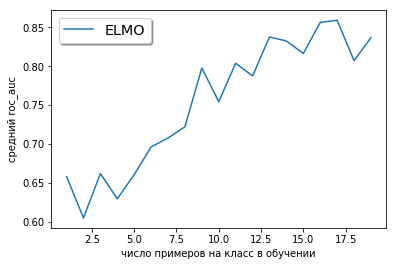

In [21]:
plt.plot(list(range(1,20)), aucs, label='ELMO')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('число примеров на класс в обучении')
plt.ylabel('средний roc_auc')
plt.show()

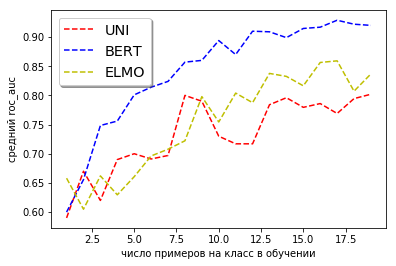

In [24]:
uni_aucs = [0.59, 0.67, 0.62, 0.69, 0.7, 0.691, 0.697, 0.8, 0.79, 0.73, 
            0.717, 0.717, 0.784, 0.796, 0.7795, 0.786, 0.769, 0.7945, 0.802]
bert_aucs = [0.6, 0.6556, 0.7484, 0.756, 0.8009, 0.814, 0.824, 0.857, 
            0.86, 0.8940, 0.87, 0.91,0.909, 0.899,  0.9147, 0.9169, 0.9288, 
            0.922, 0.92]

plt.plot(list(range(1,20)), uni_aucs, 'r--', label='UNI')
plt.plot(list(range(1,20)), bert_aucs, 'b--', label='BERT')
plt.plot(list(range(1,20)), aucs, 'y--', label='ELMO')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('число примеров на класс в обучении')
plt.ylabel('средний roc_auc')
plt.show()